In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import time
import matplotlib
# matplotlib.use("agg")
import matplotlib.pyplot as plt
import torch
import nibabel
import data.constants as constants
import nilearn.masking as masking
import numpy as np
import pandas as pd
import nibabel
from nilearn.image import load_img, resample_img, crop_img, threshold_img, math_img
import nilearn.image as niimg
import nilearn.masking as masking
from nilearn import plotting
import itertools
import torch
from torch import autograd
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gcn.modules import (
    classifiers,
)
import utils.utils as utils
from data import (
    dataset,
    constants,
    ward_tree,
)
import scipy
import scipy.special
mask = nibabel.load("/data/hcp/hcp_mask.nii.gz")
from collections import defaultdict

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
npos = mask.get_data().sum()
print(npos)

In [ ]:
md = "smallerfgl_213_sum_tree"
prefix = "test"
ds = "archi0"
fc_chk = torch.load("/data/brain_/gcn/outputs/multi_run/{}/{}/outer_split0/last.checkpoint".format("fc", ds))

chk = torch.load("/data/brain_/gcn/outputs/multi_run/{}/{}/outer_split0/last.checkpoint".format(md, ds))
args = torch.load("/data/brain_/gcn/outputs/multi_run/{}/{}/args.checkpoint".format(md, ds))
splits, meta = dataset.get_splits(
    args.study,
    args.outer_folds,
    1,
    args.dset_seed,
    random_outer=args.outer_frac,  # test, always. Not CV
    random_inner=0.0,  # No validation.
    masked=classifiers.masked[args.classifier_type],
    downsampled=args.downsampled,
    normalization=args.normalization,
    not_lazy=args.not_lazy
)

model = classifiers.versions[args.classifier_type](args, loadable_state_dict=chk['model'])
model = model.cuda()
dpm = nn.DataParallel(model)
model = model.eval()

fc = classifiers.versions["fc"](args, loadable_state_dict=fc_chk["model"])
with torch.no_grad():
    fc_weight = fc_chk['model']['net.0.weight_g'] * fc_chk['model']['net.0.weight_v']
fc_imgs = [masking.unmask(fc_weight[i].cpu().numpy(), mask) for i in range(fc_weight.shape[0])]

In [30]:
# Not good enough :<
def suitable_x(model, x, cvec, lr=0.01, niters=1000):
    start_tic = time.time()
    x = x.cuda()
    x.requires_grad_(True)
    cvec = cvec.cuda()
    optimizer = optim.Adam(
        [x],
        lr=lr,
        betas=(0.5, 0.9),
        weight_decay=0, # 1e-4,
    )
    
    for i in range(niters):
        tic = time.time()
        cpred = model(x)
        loss = F.cross_entropy(cpred, cvec)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            acc = (torch.argmax(cpred, 1)[0] == cvec).float().mean().item()
        print("[{}/{}] loss={} acc={} time={}s".format(i, niters, loss.item(), acc, time.time() - tic))
    print("loss={} acc={}".format(i, niters, loss.item(), acc))
    print("Total time elapsed = {}s".format(time.time() - start_tic))
    return x

In [28]:
cls = 20
x = suitable_x(nn.DataParallel(fc.cuda()), torch.randn(1, 212445), torch.tensor([cls]), niters=250)
imgs = [masking.unmask(x[i].detach().cpu().numpy(), mask) for i in range(x.shape[0])]

[0/250] loss=3.6856014728546143 acc=0.0 time=0.010000467300415039s
[1/250] loss=1.690032958984375 acc=1.0 time=0.010534524917602539s
[2/250] loss=0.4505743980407715 acc=1.0 time=0.01062321662902832s
[3/250] loss=0.10901117324829102 acc=1.0 time=0.010752677917480469s
[4/250] loss=0.03979778289794922 acc=1.0 time=0.010781288146972656s
[5/250] loss=0.021019458770751953 acc=1.0 time=0.010774850845336914s
[6/250] loss=0.014127731323242188 acc=1.0 time=0.010818719863891602s
[7/250] loss=0.010990142822265625 acc=1.0 time=0.010886430740356445s
[8/250] loss=0.009318351745605469 acc=1.0 time=0.010846614837646484s
[9/250] loss=0.008302688598632812 acc=1.0 time=0.010566234588623047s
[10/250] loss=0.007609367370605469 acc=1.0 time=0.010679244995117188s
[11/250] loss=0.007084846496582031 acc=1.0 time=0.010677337646484375s
[12/250] loss=0.00665283203125 acc=1.0 time=0.010706186294555664s
[13/250] loss=0.006275177001953125 acc=1.0 time=0.010745525360107422s
[14/250] loss=0.005931854248046875 acc=1.0 t

[136/250] loss=8.58306884765625e-06 acc=1.0 time=0.008196830749511719s
[137/250] loss=8.58306884765625e-06 acc=1.0 time=0.008173704147338867s
[138/250] loss=7.62939453125e-06 acc=1.0 time=0.008173465728759766s
[139/250] loss=7.62939453125e-06 acc=1.0 time=0.008209943771362305s
[140/250] loss=6.67572021484375e-06 acc=1.0 time=0.008378267288208008s
[141/250] loss=6.67572021484375e-06 acc=1.0 time=0.008373498916625977s
[142/250] loss=5.7220458984375e-06 acc=1.0 time=0.008269071578979492s
[143/250] loss=5.7220458984375e-06 acc=1.0 time=0.008196830749511719s
[144/250] loss=5.7220458984375e-06 acc=1.0 time=0.008183002471923828s
[145/250] loss=4.76837158203125e-06 acc=1.0 time=0.008208036422729492s
[146/250] loss=4.76837158203125e-06 acc=1.0 time=0.008112430572509766s
[147/250] loss=4.76837158203125e-06 acc=1.0 time=0.008290767669677734s
[148/250] loss=4.76837158203125e-06 acc=1.0 time=0.008440256118774414s
[149/250] loss=4.76837158203125e-06 acc=1.0 time=0.0083465576171875s
[150/250] loss=3.

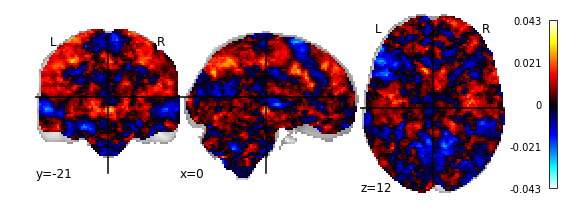

In [222]:
cls = 20
plotting.plot_stat_map(fc_imgs[cls])
# plotting.plot_stat_map(niimg.smooth_img(imgs[0], 'fast'))

# fcwt_imgs = [masking.unmask(fc.net[0].weight[i].detach().cpu().numpy(), mask) for i in range(fc_weight.shape[0])]
# plotting.plot_stat_map(fcwt_imgs[cls])


In [121]:
# Doesn't work. Probably floating point errors everywhere.
done = 0
maxbs = 256
wts = []
nbs = 1 + (npos // maxbs)
with torch.no_grad():
    dpm = dpm.eval()
    tic = time.time()
    for bidx in range(nbs):
        bs = min(maxbs, npos - done)
        x = torch.zeros(bs, npos).float()
        for i in range(bs):
            x[i, done] = 1.0
            done += 1
        x = x.cuda()
        wts.append(dpm(x))
        print("{}/{} = {}/{} at {}s".format(bidx, nbs, done, npos, time.time() - tic))
    fglwt = torch.cat(wts, 0)

0/830 = 256/212445 at 4.509754419326782s
1/830 = 512/212445 at 9.229759216308594s
2/830 = 768/212445 at 13.954073429107666s
3/830 = 1024/212445 at 18.67522692680359s
4/830 = 1280/212445 at 23.40029239654541s
5/830 = 1536/212445 at 28.126707315444946s
6/830 = 1792/212445 at 32.84716796875s
7/830 = 2048/212445 at 37.5723557472229s
8/830 = 2304/212445 at 42.290372371673584s
9/830 = 2560/212445 at 47.01295280456543s
10/830 = 2816/212445 at 51.73600625991821s
11/830 = 3072/212445 at 56.45990705490112s
12/830 = 3328/212445 at 61.18377637863159s
13/830 = 3584/212445 at 65.90837454795837s
14/830 = 3840/212445 at 70.63270020484924s
15/830 = 4096/212445 at 75.35457444190979s
16/830 = 4352/212445 at 80.07844281196594s
17/830 = 4608/212445 at 84.80227017402649s
18/830 = 4864/212445 at 89.5261583328247s
19/830 = 5120/212445 at 94.25016283988953s
20/830 = 5376/212445 at 98.97394609451294s
21/830 = 5632/212445 at 103.69715356826782s
22/830 = 5888/212445 at 108.42089438438416s
23/830 = 6144/212445 at 

185/830 = 47616/212445 at 878.4019281864166s
186/830 = 47872/212445 at 883.1271142959595s
187/830 = 48128/212445 at 887.8451483249664s
188/830 = 48384/212445 at 892.5698673725128s
189/830 = 48640/212445 at 897.2953870296478s
190/830 = 48896/212445 at 902.0195977687836s
191/830 = 49152/212445 at 906.7437014579773s
192/830 = 49408/212445 at 911.4650766849518s
193/830 = 49664/212445 at 916.1885039806366s
194/830 = 49920/212445 at 920.9110746383667s
195/830 = 50176/212445 at 925.6351597309113s
196/830 = 50432/212445 at 930.3586893081665s
197/830 = 50688/212445 at 935.0807347297668s
198/830 = 50944/212445 at 939.8051164150238s
199/830 = 51200/212445 at 944.5308895111084s
200/830 = 51456/212445 at 949.2562103271484s
201/830 = 51712/212445 at 953.9821312427521s
202/830 = 51968/212445 at 958.7055673599243s
203/830 = 52224/212445 at 963.4287650585175s
204/830 = 52480/212445 at 968.1530613899231s
205/830 = 52736/212445 at 972.8772220611572s
206/830 = 52992/212445 at 977.6015086174011s
207/830 = 

365/830 = 93696/212445 at 1728.658124923706s
366/830 = 93952/212445 at 1733.383537054062s
367/830 = 94208/212445 at 1738.1070914268494s
368/830 = 94464/212445 at 1742.8331344127655s
369/830 = 94720/212445 at 1747.559138059616s
370/830 = 94976/212445 at 1752.282695055008s
371/830 = 95232/212445 at 1757.0076930522919s
372/830 = 95488/212445 at 1761.7326068878174s
373/830 = 95744/212445 at 1766.4593839645386s
374/830 = 96000/212445 at 1771.185660123825s
375/830 = 96256/212445 at 1775.9142355918884s
376/830 = 96512/212445 at 1780.6342976093292s
377/830 = 96768/212445 at 1785.3611347675323s
378/830 = 97024/212445 at 1790.086065530777s
379/830 = 97280/212445 at 1794.8101201057434s
380/830 = 97536/212445 at 1799.5360655784607s
381/830 = 97792/212445 at 1804.259808063507s
382/830 = 98048/212445 at 1808.983113527298s
383/830 = 98304/212445 at 1813.707331418991s
384/830 = 98560/212445 at 1818.4308547973633s
385/830 = 98816/212445 at 1823.154070854187s
386/830 = 99072/212445 at 1827.8793680667877

542/830 = 139008/212445 at 2564.791417837143s
543/830 = 139264/212445 at 2569.5166580677032s
544/830 = 139520/212445 at 2574.241795539856s
545/830 = 139776/212445 at 2578.965473651886s
546/830 = 140032/212445 at 2583.692350625992s
547/830 = 140288/212445 at 2588.416950941086s
548/830 = 140544/212445 at 2593.1426577568054s
549/830 = 140800/212445 at 2597.8623995780945s
550/830 = 141056/212445 at 2602.5867400169373s
551/830 = 141312/212445 at 2607.31099653244s
552/830 = 141568/212445 at 2612.0357694625854s
553/830 = 141824/212445 at 2616.7592759132385s
554/830 = 142080/212445 at 2621.4845626354218s
555/830 = 142336/212445 at 2626.209820508957s
556/830 = 142592/212445 at 2630.931313753128s
557/830 = 142848/212445 at 2635.6536271572113s
558/830 = 143104/212445 at 2640.377016067505s
559/830 = 143360/212445 at 2645.1022157669067s
560/830 = 143616/212445 at 2649.814829826355s
561/830 = 143872/212445 at 2654.5410163402557s
562/830 = 144128/212445 at 2659.265393972397s
563/830 = 144384/212445 a

719/830 = 184320/212445 at 3400.8715555667877s
720/830 = 184576/212445 at 3405.595452308655s
721/830 = 184832/212445 at 3410.3198795318604s
722/830 = 185088/212445 at 3415.0446112155914s
723/830 = 185344/212445 at 3419.7690556049347s
724/830 = 185600/212445 at 3424.492786884308s
725/830 = 185856/212445 at 3429.217292547226s
726/830 = 186112/212445 at 3433.9421133995056s
727/830 = 186368/212445 at 3438.6551752090454s
728/830 = 186624/212445 at 3443.3804001808167s
729/830 = 186880/212445 at 3448.1042783260345s
730/830 = 187136/212445 at 3452.8297905921936s
731/830 = 187392/212445 at 3457.553904056549s
732/830 = 187648/212445 at 3462.277556657791s
733/830 = 187904/212445 at 3466.9969096183777s
734/830 = 188160/212445 at 3471.7198832035065s
735/830 = 188416/212445 at 3476.449816465378s
736/830 = 188672/212445 at 3481.1757805347443s
737/830 = 188928/212445 at 3485.8991804122925s
738/830 = 189184/212445 at 3490.6218798160553s
739/830 = 189440/212445 at 3495.345254421234s
740/830 = 189696/212

In [131]:
fglwt_np = fglwt.detach().cpu().numpy()
fgl_imgs = [masking.unmask(fglwt_np[:, i], mask) for i in range(fglwt.shape[1])]

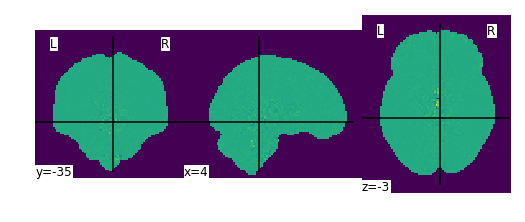

In [132]:
plotting.plot_img(fgl_imgs[5])

In [15]:
np.linalg.matrix_rank(chk['model']['downsample2.ft_weight_v'].cpu().numpy())

64

### Mathing our way to interpreting FGL
One FGL layer is $$o = A(x^{\top}v)\cdot u)$$
Expanding it out, it becomes $$o_{p,j} = \sum_{i\in Children(p)} u_{i,j} \sum_{k=1}^{c_{in}} x_{i,k}, v_{k,j}$$

We stack this thrice. Layer 1 first,
$$o_{p,j}^{(1)} = \sum_{i_1\in Children^{(1)}(p)} u_{i_1,j}^{(1)} \sum_{k=1}^{c_{in}} x_{i_1, k} v_{k, j}^{(1)}$$
Layer 2 is:
$$o_{p,j}^{(2)} = \sum_{i\in Children^{(2)}(p)} u_{i,j}^{(2)} \sum_{k=1}^{c_{in}^{(2)}} o_{i, k}^{(1)} v_{k, j}^{(2)}$$
$$o_{i_3,j}^{(2)} = \sum_{i_2\in Children^{(2)}(i_3)} u_{i_2,j}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (\sum_{i_1\in Children^{(1)}(i_2)} u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, j}^{(2)}$$

Layer 3 is:
$$o_{p,j}^{(3)} = \sum_{i\in Children^{(3)}(p)} u_{i,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} o_{i, k_3}^{(2)} v_{k_3, j}^{(3)}$$

$$o_{p,j}^{(3)} = \sum_{i_3\in Children^{(3)}(p)} u_{i_3,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} (\sum_{i_2\in Children^{(2)}(i_3)} u_{i_2,k_3}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (\sum_{i_1\in Children^{(1)}(i_2)} u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, k_3}^{(2)}) v_{k_3, j}^{(3)}$$

Rearranging terms
$$o_{p,j}^{(3)} = \sum_{k_3}^{c_{in}^{(3)}} \sum_{k_2}^{c_{in}^{(2)}} \sum_{k_1}^{c_{in}^{(1)}} \sum_{i_3\in Children^{(3)}(p)} \sum_{i_2\in Children^{(2)}(i_3)} \sum_{i_1\in Children^{(1)}(i_2)} x_{i_1, k_1} u_{i_3, j}^{(3)} u_{i_2, k_3}^{(2)} u_{i_1, k_2}^{(1)} v_{k_1, k_2}^{(1)} v_{k_2, k_3}^{(2)} v_{k_3, j}^{(3)}$$

Since each FGL layer follows a tree structure, Each $x_{i_1}$ affects only ONE $o_{p, :}$... so given a $i_1$, there is only one $i_2, i_3, p$. Hence, we rewrite our equation as:
$$o_{p, j}^{(3)} = x_{i_1, k_1} \sum_{k_3}^{c_{in}^{(3)}} \sum_{k_2}^{c_{in}^{(2)}} u_{i_3, j}^{(3)} u_{i_2, k_3}^{(2)} u_{i_1, k_2}^{(1)} v_{k_1, k_2}^{(1)} v_{k_2, k_3}^{(2)} v_{k_3, j}^{(3)} $$
for $i_2, i_3, p$ determined by the parents relationship

Further, $$y^{(c)} = \sum_{p, j} w^{(c)}_{p, j} o^{(3)}_{p, j}$$

In [154]:
childrens = {}
parents = {}
for i in range(1, 4):
    layer = getattr(model, 'downsample{}'.format(i-1))
    parents[i] = layer.indices.detach().cpu().numpy()[0, 0]
    childrens[i] = [[] for _ in range(layer.outn)]
    inds = layer.indices[0, 0].detach().cpu().numpy().astype(np.int)
    for idx, par in enumerate(inds):
        childrens[i][par].append(idx)
p2i1 = [[] for _ in range(len(childrens[3]))]
for p in range(len(childrens[3])):
    for i3 in childrens[3][p]:
        for i2 in childrens[2][i3]:
            p2i1[p].extend(childrens[1][i2])
i12p = {}
for p, i1s in enumerate(p2i1):
    for i in i1s:
        i12p[i] = p
        
cin1 = 1
cin2 = model.downsample0.outc
cin3 = model.downsample1.outc
with torch.no_grad():
    u1 = 10 * (model.downsample0.nf_weight_g * model.downsample0.nf_weight_v).detach().cpu().numpy()
    u2 = 10 * (model.downsample1.nf_weight_g * model.downsample1.nf_weight_v).detach().cpu().numpy()
    u3 = 10 * (model.downsample2.nf_weight_g * model.downsample2.nf_weight_v).detach().cpu().numpy()
    v1 = 10 * (model.downsample0.ft_weight_g * model.downsample0.ft_weight_v).detach().cpu().numpy()
    v2 = 10 * (model.downsample1.ft_weight_g * model.downsample1.ft_weight_v).detach().cpu().numpy()
    v3 = 10 * (model.downsample2.ft_weight_g * model.downsample2.ft_weight_v).detach().cpu().numpy()

In [118]:
fgl_weight = np.zeros(fc_weight.shape)
# Far too slow! 36 days!
with torch.no_grad():
    for c in range(fgl_weight.shape[0]):
        reshaped_weight = model.fc[0].weight[c].view(model.downsample2.outc, model.downsample2.outn).detach().cpu().numpy()
        for i1 in range(fgl_weight.shape[1]):
            tic = time.time()
            # affect of x_i on y_c
            i2 = parents[1][i1]
            i3 = parents[2][i2]
            p = parents[3][i3]
            for j in range(model.downsample2.outc):
                for k2 in range(cin2):
                    for k3 in range(cin3):
                        a = reshaped_weight[j, p]
                        us = u3[j, i3] * u2[k3, i2] * u1[k2, i1]
                        vs = v3[k3, j] * v2[k2, k3] * v1[0, k2]
                        fgl_weight[c, i1] += a * us * vs
            print('Computed fgl_weight[{}, {}] in {}'.format(c, i1, time.time() - tic))

Computed fgl_weight[0, 0] in 0.5575704574584961
Computed fgl_weight[0, 1] in 0.5619003772735596
Computed fgl_weight[0, 2] in 0.5592238903045654
Computed fgl_weight[0, 3] in 0.5607223510742188
Computed fgl_weight[0, 4] in 0.5599029064178467
Computed fgl_weight[0, 5] in 0.5606622695922852
Computed fgl_weight[0, 6] in 0.5602779388427734
Computed fgl_weight[0, 7] in 0.561215877532959
Computed fgl_weight[0, 8] in 0.560652494430542
Computed fgl_weight[0, 9] in 0.5589587688446045
Computed fgl_weight[0, 10] in 0.5601458549499512
Computed fgl_weight[0, 11] in 0.5595133304595947
Computed fgl_weight[0, 12] in 0.5601305961608887
Computed fgl_weight[0, 13] in 0.5601422786712646
Computed fgl_weight[0, 14] in 0.5607867240905762
Computed fgl_weight[0, 15] in 0.5620017051696777
Computed fgl_weight[0, 16] in 0.5591108798980713
Computed fgl_weight[0, 17] in 0.5567822456359863
Computed fgl_weight[0, 18] in 0.5623502731323242
Computed fgl_weight[0, 19] in 0.5584151744842529
Computed fgl_weight[0, 20] in 0.

KeyboardInterrupt: 

In [212]:
# Optimizing above cell block
fgl_weight_opt = np.zeros(fc_weight.shape)
p_visited = defaultdict(lambda: 0)
with torch.no_grad():
    for c in range(fgl_weight.shape[0]):
        reshaped_weight = (model.fc[0].weight_g * model.fc[0].weight_v)[c].view(model.downsample2.outc, model.downsample2.outn).detach().cpu().numpy()
        tic = time.time()
        for i1 in range(fgl_weight.shape[1]):    
            # affect of x_i on y_c
            i2 = parents[1][i1]
            i3 = parents[2][i2]
            p = parents[3][i3]
            p_visited[p] += 1
            theta = (v1 @ np.diag(u1[:, i1]) @ v2)
            theta = (theta @ np.diag(u2[:, i2]) @ v3)
            fgl_weight_opt[c, i1] += (reshaped_weight[:, p] * theta[0, :] * u3[:, i3]).sum()
        print('Computed fgl_weight[{}, :] in {}'.format(c, time.time() - tic))

Computed fgl_weight[0, :] in 5.976105451583862
Computed fgl_weight[1, :] in 6.092447519302368
Computed fgl_weight[2, :] in 5.581674575805664
Computed fgl_weight[3, :] in 5.508243560791016
Computed fgl_weight[4, :] in 5.608417510986328
Computed fgl_weight[5, :] in 5.4972984790802
Computed fgl_weight[6, :] in 5.5811686515808105
Computed fgl_weight[7, :] in 5.544186592102051
Computed fgl_weight[8, :] in 5.802761077880859
Computed fgl_weight[9, :] in 5.524154424667358
Computed fgl_weight[10, :] in 5.581283330917358
Computed fgl_weight[11, :] in 5.5074074268341064
Computed fgl_weight[12, :] in 5.570366144180298
Computed fgl_weight[13, :] in 5.547985792160034
Computed fgl_weight[14, :] in 5.567530155181885
Computed fgl_weight[15, :] in 5.668049335479736
Computed fgl_weight[16, :] in 6.192400932312012
Computed fgl_weight[17, :] in 5.495763063430786
Computed fgl_weight[18, :] in 5.5867743492126465
Computed fgl_weight[19, :] in 6.127179384231567
Computed fgl_weight[20, :] in 5.686997413635254
C

In [226]:
fgl_imgs = [masking.unmask(np.clip(fgl_weight_opt[i, :] / 100000, -10, 10), mask) for i in range(fgl_weight_opt.shape[0])]

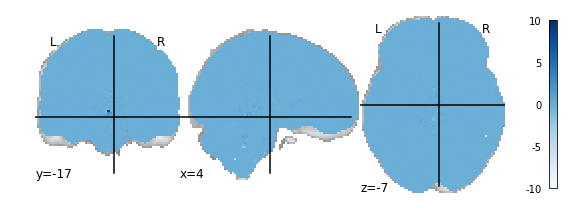

In [227]:
plotting.plot_stat_map(fgl_imgs[5], cmap=plt.get_cmap('Blues'))

## Importance with bias accounted for
$$o_{p,j}^{(1)} = b^{(1)}_{p, j} + \sum_{i_1\in Children^{(1)}(p)} u_{i_1,j}^{(1)} \sum_{k=1}^{c_{in}} x_{i_1, k} v_{k, j}^{(1)}$$


$$o_{p,j}^{(3)} = b^{(3)}_{p, j} + \sum_{i_3\in Children^{(3)}(p)} u_{i_3,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} (b^{(2)}_{i_3, k_3} + \sum_{i_2\in Children^{(2)}(i_3)} u_{i_2,k_3}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (b^{(1)}_{i_2, k_2} + \sum_{i_1\in Children^{(1)}(i_2)} u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, k_3}^{(2)}) v_{k_3, j}^{(3)}$$

$$o_{p,j}^{(3)} = b^{(3)}_{p, j} + u_{i_3,j}^{(3)} \sum_{k_3=1}^{c_{in}^{(3)}} (b^{(2)}_{i_3, k_3} + u_{i_2,k_3}^{(2)} \sum_{k_2=1}^{c_{in}^{(2)}} (b^{(1)}_{i_2, k_2} + u_{i_1,k_2}^{(1)} \sum_{k_1=1}^{c_{in}^{(1)}} x_{i_1, k_1} v_{k_1, k_2}^{(1)}) v_{k_2, k_3}^{(2)}) v_{k_3, j}^{(3)}$$

Confirmed, bias doesn't matter

In [169]:
lol = (fgl_weight_opt / 1000000)

In [171]:
lol.min()

-38.468036

(array([ 128069.,  187106.,  293700.,  519829., 1356170., 1355714.,
         521661.,  293747.,  187644.,  128041.]),
 array([-0.01 , -0.008, -0.006, -0.004, -0.002,  0.   ,  0.002,  0.004,
         0.006,  0.008,  0.01 ]),
 <a list of 10 Patch objects>)

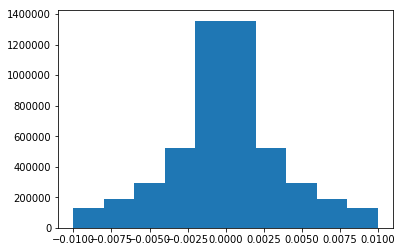

In [193]:
plt.hist(np.reshape(lol, (-1,)), range=(-0.01, 0.01))

(array([1.120000e+02, 1.595000e+03, 1.648400e+04, 2.694040e+05,
        2.037481e+06, 3.190946e+06, 8.011320e+05, 5.361000e+04,
        2.470000e+03, 1.160000e+02]),
 array([-0.08833417, -0.07142329, -0.05451242, -0.03760153, -0.02069066,
        -0.00377978,  0.0131311 ,  0.03004198,  0.04695286,  0.06386374,
         0.08077462], dtype=float32),
 <a list of 10 Patch objects>)

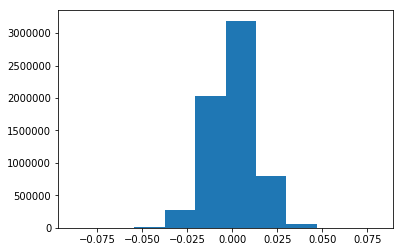

In [176]:
plt.hist(np.reshape(fc_weight.cpu().numpy(), (-1,)))

In [199]:
model.fc[0].weight_g

Parameter containing:
tensor([[0.5749],
        [0.5726],
        [0.5772],
        [0.5843],
        [0.5759],
        [0.5821],
        [0.5732],
        [0.5732],
        [0.5727],
        [0.5775],
        [0.5770],
        [0.5808],
        [0.5796],
        [0.5782],
        [0.5820],
        [0.5799],
        [0.5805],
        [0.5798],
        [0.5817],
        [0.5790],
        [0.5829],
        [0.5773],
        [0.5786],
        [0.5694],
        [0.5766],
        [0.5683],
        [0.5828],
        [0.5786],
        [0.5746],
        [0.5776]], device='cuda:0', requires_grad=True)

In [217]:
sum(v for k, v in p_visited.items()) / 30

212445.0

## Visualize linear weights from any layer 

In [11]:
# Loading model
exp = "gcn"
md = "smallerfgl_213_sum_tree"
prefix = "test"
ds = "archi0"
chk = torch.load("/data/brain_/{}/outputs/multi_run/{}/{}/outer_split0/last.checkpoint".format(exp, md, ds))
args = torch.load("/data/brain_/{}/outputs/multi_run/{}/{}/args.checkpoint".format(exp, md, ds))
splits, meta = dataset.get_splits(
    args.study,
    args.outer_folds,
    1,
    args.dset_seed,
    random_outer=args.outer_frac,  # test, always. Not CV
    random_inner=0.0,  # No validation.
    masked=classifiers.masked[args.classifier_type],
    downsampled=args.downsampled,
    normalization=args.normalization,
    not_lazy=args.not_lazy
)

model = classifiers.versions[args.classifier_type](args, loadable_state_dict=chk['model'])
model = model.cuda()
dpm = nn.DataParallel(model)
model = model.eval()

n_regions=32 >= level_size=32 is not allowed. setting n_regions < level_size
Using corrected initialization
FGL: Using tree optimization
Using corrected initialization
FGL: Using tree optimization
Using corrected initialization
FGL: Using tree optimization


In [26]:
childrens = {}
parents = {}
for i in range(1, 4):
    layer = getattr(model, 'downsample{}'.format(i-1))
    parents[i] = layer.indices.detach().cpu().numpy()[0, 0]
    childrens[i] = [[] for _ in range(layer.outn)]
    inds = layer.indices[0, 0].detach().cpu().numpy().astype(np.int)
    for idx, par in enumerate(inds):
        childrens[i][par].append(idx)

p2i1 = [[] for _ in range(len(childrens[3]))]
for p in range(len(childrens[3])):
    for i3 in childrens[3][p]:
        for i2 in childrens[2][i3]:
            p2i1[p].extend(childrens[1][i2])

i12p = {}
for p, i1s in enumerate(p2i1):
    for i in i1s:
        i12p[i] = p

cs = {
    0: 1,
    1: model.downsample0.outc,
    2: model.downsample1.outc,
    3: model.downsample2.outc,
}

ns = {
    0: model.downsample0.inn,
    1: model.downsample1.inn,
    2: model.downsample2.inn,
    3: model.downsample2.outn,
}

us = {}
vs = {}
with torch.no_grad():
    us[1] = (model.downsample0.nf_weight_g * model.downsample0.nf_weight_v).detach().cpu().numpy()
    us[2] = (model.downsample1.nf_weight_g * model.downsample1.nf_weight_v).detach().cpu().numpy()
    us[3] = (model.downsample2.nf_weight_g * model.downsample2.nf_weight_v).detach().cpu().numpy()
    vs[1] = (model.downsample0.ft_weight_g * model.downsample0.ft_weight_v).detach().cpu().numpy()
    vs[2] = (model.downsample1.ft_weight_g * model.downsample1.ft_weight_v).detach().cpu().numpy()
    vs[3] = (model.downsample2.ft_weight_g * model.downsample2.ft_weight_v).detach().cpu().numpy()

fglw = (model.fc[0].weight_g * model.fc[0].weight_v).detach().cpu().numpy()  # Weight of fc layer
nclasses = fglw.shape[0]
fglw = np.reshape(fglw, (nclasses, cs[3], ns[3]))

In [27]:
importances = {
    i: np.zeros((nclasses, cs[i], ns[i])) for i in range(4)
}

In [28]:
with torch.no_grad():
    # Start at layer 3's output
    importances[3] = fglw
    
    # Importances for layer 2's output
    tic = time.time()
    for c in range(nclasses):
        for i3 in range(ns[2]):
            # for k in range(cs[2]):
            p = parents[3][i3]
            importances[2][c, :, i3] += us[3][:, i3] @ np.diag(fglw[c, :, p]) @ vs[3].T
    print("importances[2]: {}".format(time.time() - tic))
    
    # Importance of layer 1's output
    tic = time.time()
    for c in range(nclasses):
        for i2 in range(ns[1]):
            i3 = parents[2][i2]
            p = parents[3][i3]
            theta = us[3][:, i3] @ np.diag(fglw[c, :, p]) @ vs[3].T  # k3 sized vector
            importances[1][c, :, i2] += us[2][:, i2] @ np.diag(theta) @ vs[2].T
    print("importances[1]: {}".format(time.time() - tic))
    # Importance of input
    tic = time.time()
    for c in range(nclasses):
        for i1 in range(ns[0]):    
            # affect of x_i on y_c
            i2 = parents[1][i1]
            i3 = parents[2][i2]
            p = parents[3][i3]
            theta = us[3][:, i3] @ np.diag(fglw[c, :, p]) @ vs[3].T  # k3 sized vector
            theta = us[2][:, i2] @ np.diag(theta) @ vs[2].T
            importances[0][c, :, i1] += us[1][:, i1] @ np.diag(theta) @ vs[1].T
    print("importances[0]: {}".format(time.time() - tic))

importances[2]: 6.9755964279174805
importances[1]: 49.14119291305542
importances[0]: 1368.1241619586945


In [22]:
importances[1].shape

(30, 32, 1024)

In [23]:
taking_indices = {
    i: model.args.wtree.cut(ns[i]) for i in ns.keys()
}

In [24]:
def get_niimg(layer_idx, cls=0, channel_idx=0, clip=0.1):
    arr = np.take(importances[layer_idx][cls, channel_idx, :], taking_indices[layer_idx])
    niimg = masking.unmask(np.clip(arr, -clip, clip), mask)
    return niimg

In [25]:
plotting.plot_stat_map(get_niimg(3, cls=0, channel_idx=1, clip=0.1), cmap=plt.get_cmap('red'))

ValueError: Colormap red is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, black_blue, black_blue_r, black_green, black_green_r, black_pink, black_pink_r, black_purple, black_purple_r, black_red, black_red_r, blue_orange, blue_orange_r, blue_red, blue_red_r, blue_transparent, blue_transparent_full_alpha_range, bone, bone_r, brg, brg_r, brown_blue, brown_blue_r, brown_cyan, brown_cyan_r, bwr, bwr_r, cividis, cividis_r, cold_hot, cold_hot_r, cold_white_hot, cold_white_hot_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, cyan_copper, cyan_copper_r, cyan_orange, cyan_orange_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, green_transparent, green_transparent_full_alpha_range, hot, hot_black_bone, hot_black_bone_r, hot_r, hot_white_bone, hot_white_bone_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_hot, ocean_hot_r, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, purple_blue, purple_blue_r, purple_green, purple_green_r, rainbow, rainbow_r, red_transparent, red_transparent_full_alpha_range, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

In [ ]:
plotting.plot_stat_map(get_niimg(1, cls=0, channel_idx=0, clip=0.1), cmap=plt.get_cmap('hot_r'))

In [7]:
model.downsample0.bias

torch.Size([1, 32, 1024])

### Qualitative analysis
Figure out what kind of mistakes the model makes

In [44]:
incorrect = defaultdict(list)
for idx, (x, _, _, c) in enumerate(splits[0]['test']):
    tic = time.time()
    cpred = torch.argmax(model(torch.from_numpy(x).unsqueeze(0).cuda()), dim=1)[0].item()  # Single batch
    if cpred != c:
        incorrect[c].append(idx)
    print("[{}] t={} c={} cpred={}".format(idx, time.time() - tic, c, cpred))

[0] t=0.009836196899414062 c=17 cpred=23
[1] t=0.01901721954345703 c=25 cpred=4
[2] t=0.07559895515441895 c=18 cpred=26
[3] t=0.03760790824890137 c=18 cpred=15
[4] t=0.009114742279052734 c=15 cpred=5
[5] t=0.008543729782104492 c=22 cpred=22
[6] t=0.009360790252685547 c=2 cpred=18
[7] t=0.01411890983581543 c=11 cpred=22
[8] t=0.008875846862792969 c=9 cpred=22
[9] t=0.009177923202514648 c=13 cpred=4
[10] t=0.017262935638427734 c=9 cpred=25
[11] t=0.009114980697631836 c=5 cpred=1
[12] t=0.015477418899536133 c=0 cpred=12
[13] t=0.0806736946105957 c=13 cpred=12
[14] t=0.04879355430603027 c=13 cpred=7
[15] t=0.009131908416748047 c=20 cpred=4
[16] t=0.008534431457519531 c=16 cpred=6
[17] t=0.009489774703979492 c=28 cpred=15
[18] t=0.013701677322387695 c=24 cpred=13
[19] t=0.00854802131652832 c=28 cpred=14
[20] t=0.009389638900756836 c=11 cpred=15
[21] t=0.013637304306030273 c=12 cpred=23
[22] t=0.00894618034362793 c=1 cpred=12
[23] t=0.01042628288269043 c=2 cpred=18
[24] t=0.01718330383300781

[199] t=0.08461475372314453 c=13 cpred=25
[200] t=0.05189156532287598 c=17 cpred=27
[201] t=0.01369476318359375 c=19 cpred=11
[202] t=0.008937597274780273 c=13 cpred=25
[203] t=0.018804311752319336 c=4 cpred=26
[204] t=0.08369135856628418 c=4 cpred=12
[205] t=0.008573055267333984 c=5 cpred=12
[206] t=0.008844852447509766 c=14 cpred=4
[207] t=0.008594751358032227 c=3 cpred=26
[208] t=0.00854635238647461 c=29 cpred=12
[209] t=0.008541345596313477 c=26 cpred=4
[210] t=0.008530378341674805 c=17 cpred=13
[211] t=0.008550405502319336 c=15 cpred=16
[212] t=0.00855708122253418 c=3 cpred=26
[213] t=0.008520364761352539 c=12 cpred=3
[214] t=0.008529424667358398 c=3 cpred=8
[215] t=0.008550167083740234 c=7 cpred=18
[216] t=0.008557319641113281 c=17 cpred=6
[217] t=0.00854039192199707 c=0 cpred=12
[218] t=0.008534908294677734 c=16 cpred=1
[219] t=0.0165865421295166 c=27 cpred=12
[220] t=0.013816118240356445 c=8 cpred=7
[221] t=0.008685827255249023 c=1 cpred=12
[222] t=0.009610414505004883 c=18 cpr

[394] t=0.0715632438659668 c=14 cpred=6
[395] t=0.008559703826904297 c=27 cpred=17
[396] t=0.009249210357666016 c=17 cpred=13
[397] t=0.01790904998779297 c=10 cpred=11
[398] t=0.07118678092956543 c=13 cpred=7
[399] t=0.08938264846801758 c=26 cpred=12
[400] t=0.06100773811340332 c=10 cpred=1
[401] t=0.009426593780517578 c=10 cpred=26
[402] t=0.008548736572265625 c=21 cpred=15
[403] t=0.020746231079101562 c=11 cpred=23
[404] t=0.01514577865600586 c=11 cpred=4
[405] t=0.009150028228759766 c=26 cpred=28
[406] t=0.023107051849365234 c=6 cpred=12
[407] t=0.048932552337646484 c=29 cpred=15
[408] t=0.03375959396362305 c=2 cpred=12
[409] t=0.014242887496948242 c=1 cpred=12
[410] t=0.009230375289916992 c=19 cpred=0
[411] t=0.019078969955444336 c=23 cpred=26
[412] t=0.07037901878356934 c=21 cpred=13
[413] t=0.023382186889648438 c=18 cpred=12
[414] t=0.04688215255737305 c=9 cpred=1
[415] t=0.008763551712036133 c=4 cpred=6
[416] t=0.009351491928100586 c=12 cpred=11
[417] t=0.01165151596069336 c=3 c

[590] t=0.06861996650695801 c=23 cpred=12
[591] t=0.012060880661010742 c=9 cpred=10
[592] t=0.008613109588623047 c=11 cpred=4
[593] t=0.03838086128234863 c=26 cpred=15
[594] t=0.009209632873535156 c=1 cpred=12
[595] t=0.008545398712158203 c=4 cpred=26
[596] t=0.05320382118225098 c=3 cpred=25
[597] t=0.009769916534423828 c=4 cpred=13
[598] t=0.008809089660644531 c=21 cpred=15
[599] t=0.054892539978027344 c=6 cpred=13
[600] t=0.009200096130371094 c=20 cpred=26
[601] t=0.010224342346191406 c=23 cpred=12
[602] t=0.05932021141052246 c=0 cpred=12
[603] t=0.014791488647460938 c=23 cpred=3
[604] t=0.008502960205078125 c=4 cpred=1
[605] t=0.05487513542175293 c=20 cpred=1
[606] t=0.010411262512207031 c=23 cpred=23
[607] t=0.008583307266235352 c=27 cpred=15
[608] t=0.05167198181152344 c=9 cpred=1
[609] t=0.009099006652832031 c=1 cpred=26
[610] t=0.008539915084838867 c=9 cpred=22
[611] t=0.0567326545715332 c=3 cpred=20
[612] t=0.009254693984985352 c=7 cpred=12
[613] t=0.008526325225830078 c=27 cpr

In [48]:
args.meta['c2i']

{'audio': 23,
 'calculaudio': 17,
 'calculvideo': 21,
 'clicDaudio': 14,
 'clicDvideo': 18,
 'clicGaudio': 15,
 'clicGvideo': 13,
 'computation': 16,
 'damier_H': 19,
 'damier_V': 22,
 'expression_control': 29,
 'expression_intention': 25,
 'expression_sex': 26,
 'face_control': 27,
 'face_sex': 28,
 'face_trusty': 24,
 'false_belief_audio': 2,
 'false_belief_video': 5,
 'mecanistic_audio': 6,
 'mecanistic_video': 4,
 'motor-cognitive': 20,
 'non_speech': 1,
 'object_grasp': 11,
 'object_orientation': 10,
 'rotation_hand': 12,
 'rotation_side': 9,
 'saccade': 8,
 'speech': 0,
 'triangle_intention': 3,
 'triangle_random': 7}

In [49]:
meta['c2i']

{'audio': 23,
 'calculaudio': 17,
 'calculvideo': 21,
 'clicDaudio': 14,
 'clicDvideo': 18,
 'clicGaudio': 15,
 'clicGvideo': 13,
 'computation': 16,
 'damier_H': 19,
 'damier_V': 22,
 'expression_control': 29,
 'expression_intention': 25,
 'expression_sex': 26,
 'face_control': 27,
 'face_sex': 28,
 'face_trusty': 24,
 'false_belief_audio': 2,
 'false_belief_video': 5,
 'mecanistic_audio': 6,
 'mecanistic_video': 4,
 'motor-cognitive': 20,
 'non_speech': 1,
 'object_grasp': 11,
 'object_orientation': 10,
 'rotation_hand': 12,
 'rotation_side': 9,
 'saccade': 8,
 'speech': 0,
 'triangle_intention': 3,
 'triangle_random': 7}

In [52]:
model.downsample0.indices

tensor([[[906, 906, 278,  ..., 945, 945, 945]]], device='cuda:0')

In [72]:
model = classifiers.versions['eqsmallerfgl'](args, loadable_state_dict=chk['model'])

n_regions=32 >= level_size=32 is not allowed. setting n_regions < level_size
torch.Size([212445])
torch.Size([32, 1024])
torch.Size([32, 212445])
FGL: Using tree optimization
torch.Size([1024])
torch.Size([64, 256])
torch.Size([64, 1024])
FGL: Using tree optimization
torch.Size([256])
torch.Size([128, 32])
torch.Size([128, 256])
FGL: Using tree optimization


In [77]:
model.downsample0.nf_weight[:, 0]

tensor([ -2.4103, -16.7244, -28.2230,  24.2138, -25.6966, -21.1083, -16.6514,
        -21.7860, -16.3486, -36.4387,  27.7138,   8.3089,  18.8358, -42.0256,
         20.5803, -31.7147,   8.5574,  -0.4977,  35.8301, -34.5487,  -3.0937,
        -14.6123,  36.0855, -27.4781, -12.6308,   3.7656,  -7.3737,  17.0679,
        -14.5260, -26.1787,   5.3096,  41.8721], grad_fn=<SelectBackward>)

In [79]:
model.downsample0.indices

tensor([[[906, 906, 278,  ..., 945, 945, 945]]])

In [80]:
model.downsample0.nf_weight[:, 1]

tensor([ -2.4103, -16.7244, -28.2230,  24.2138, -25.6966, -21.1083, -16.6514,
        -21.7860, -16.3486, -36.4387,  27.7138,   8.3089,  18.8358, -42.0256,
         20.5803, -31.7147,   8.5574,  -0.4977,  35.8301, -34.5487,  -3.0937,
        -14.6123,  36.0855, -27.4781, -12.6308,   3.7656,  -7.3737,  17.0679,
        -14.5260, -26.1787,   5.3096,  41.8721], grad_fn=<SelectBackward>)

In [95]:
from clevr import somewhat, notso

In [96]:
dset = notso.NotSoClevr(s=128, l=13)

Text(0.5,1,'quad=3')

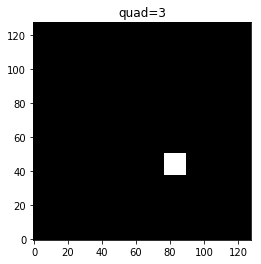

In [104]:
x, y = dset[dset.n // 3]
plt.imshow(x, cmap='gray', origin='lower')
plt.title('quad={}'.format(y))

In [102]:
dset.Ytyou

3